In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
model_files = ["Weak_1_binary_results.csv", "Weak_2_binary_results.csv", 
               "Weak_3_binary_results.csv", "Weak_4_binary_results.csv", "Weak_5_binary_results.csv", 
               "Weak_6_binary_results.csv", "Weak_7_binary_results.csv"]  
predictions = []

for file in model_files:
    df = pd.read_csv(file)
    predictions.append(df['y_pred_binary'].values)

In [3]:
# Majority voting işlemi
predictions_array = np.array(predictions)  # Shape: (model_sayısı, örnek_sayısı)
y_pred_binary_majority = np.round(predictions_array.mean(axis=0)).astype(int)  # Majority voting

# İlk modelin y_test_binary değerini örnek olarak alın (tüm modellerde aynı olmalı)
y_test_binary = pd.read_csv(model_files[0])['y_test_binary'].values

In [4]:
# Performans metrikleri
accuracy = accuracy_score(y_test_binary, y_pred_binary_majority)
precision = precision_score(y_test_binary, y_pred_binary_majority)
recall = recall_score(y_test_binary, y_pred_binary_majority)
balanced_accuracy = balanced_accuracy_score(y_test_binary, y_pred_binary_majority)
f1 = f1_score(y_test_binary, y_pred_binary_majority)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.61
Precision: 0.59
Recall: 0.72
Balanced Accuracy: 0.61
F1 Score: 0.65


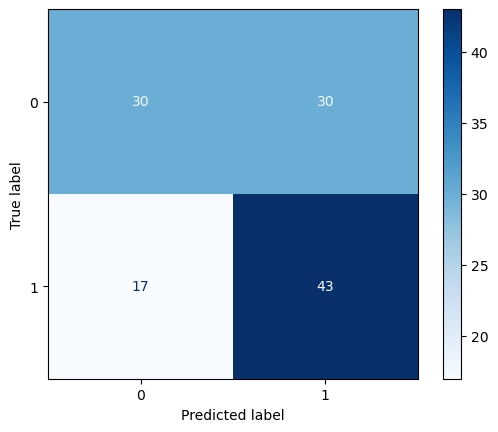

In [5]:
# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary_majority)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('majority_conf_mat.png')
plt.show()

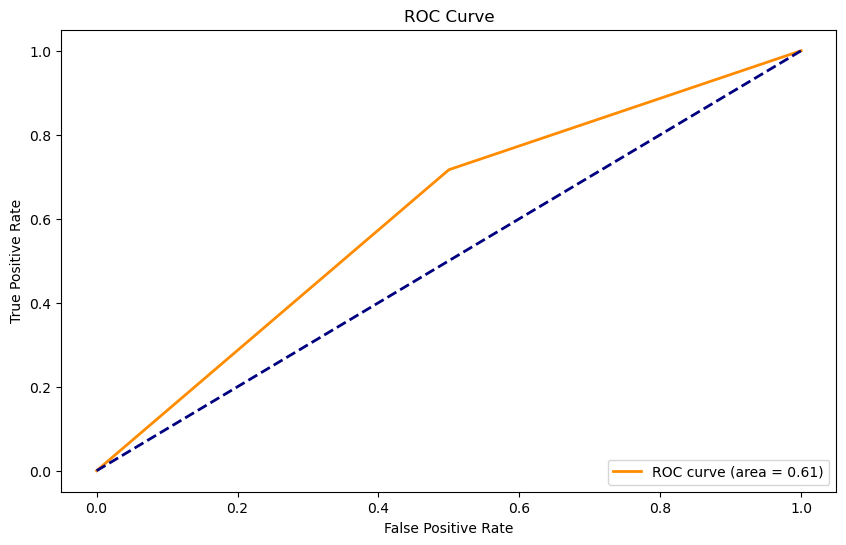

In [6]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary_majority)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('majority_roc.png')
plt.show()

FINANCIAL EVAL

In [7]:
stock_name = 'PEP'
file_name = f'{stock_name}.csv'
df = pd.read_csv(file_name)
close_prices = df['Close']

In [8]:
df = df.drop(index=0)
df = df.drop(['High', 'Low', 'Volume', 'Adj Close'], axis=1)
y_pred_binary_majority = y_pred_binary_majority.flatten()
df.loc[len(df) - len(y_pred_binary_majority) + 1:len(df), 'y_test_pred_binary'] = y_pred_binary_majority
new_df = df[['Date', 'Open', 'Close','y_test_pred_binary']].copy()
df = new_df.tail(len(y_pred_binary_majority))
df = df.reset_index(drop=True)

In [9]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
df['signal'] = ''

if df['y_test_pred_binary'].iloc[0] == 1:
    df.at[0, 'signal'] = 'buy'
elif df['y_test_pred_binary'].iloc[0] == 0:
    df.at[0, 'signal'] = 'sell'

for i in range(1, len(df)):
    if df['y_test_pred_binary'].iloc[i] != df['y_test_pred_binary'].iloc[i - 1]:
        if df['y_test_pred_binary'].iloc[i] == 1:
            df.at[i, 'signal'] = 'buy'
        elif df['y_test_pred_binary'].iloc[i] == 0:
            df.at[i, 'signal'] = 'sell'
    else:
        df.at[i, 'signal'] = ''

In [10]:
capital = 10000
stock_quantity = 0
borrowed_stock = 0
remaining_money_list = []
new_stock_list = []
borrowed_stock_list = []
#for visualisation start
total_value = 0
total_value_list = []
#bh:buy and hold
bh_value = 0
bh_value_list = []
first_opening = df.loc[0, 'Open']
bh_stock_quantity = capital / first_opening
#for visualisation end

for index, row in df.iterrows():
    signal = row['signal']
    opening_price = row['Open']

    if signal == 'buy':
        if borrowed_stock > 0:
            capital -= borrowed_stock*opening_price
            borrowed_stock = 0
        stock_quantity = capital / opening_price
        capital -= stock_quantity * opening_price
    elif signal == 'sell':
        capital += stock_quantity * opening_price
        stock_quantity = 0
        borrowed_stock = capital / opening_price
        capital += borrowed_stock*opening_price

    #for visualisation start
    closing_price = row['Close']
    total_value = (stock_quantity*closing_price)+(capital-(borrowed_stock*closing_price))
    total_value_list.append(total_value)
    bh_value = bh_stock_quantity*closing_price
    bh_value_list.append(bh_value)
    #for visualisation end
    remaining_money_list.append(capital)
    new_stock_list.append(stock_quantity)
    borrowed_stock_list.append(borrowed_stock)

df['Remaining_Money'] = remaining_money_list
df['New_Stock'] = new_stock_list
df['Borrowed_Stock'] = borrowed_stock_list
df['Total_Value'] = total_value_list
df['BH_Value'] = bh_value_list

print("Remaining Money")
remaining_money = df.loc[len(df) - 1, 'Remaining_Money']
print(remaining_money)
new_stock = df.loc[len(df) - 1, 'New_Stock']
print("New Stock")
print(new_stock)
print("Borrowed Stock")
borrowed = df.loc[len(df) - 1, 'Borrowed_Stock']
print(borrowed)
final_close = df.loc[len(df) - 1, 'Close']
print("Final Close")
print(final_close)
final_capital = ((final_close*new_stock)+remaining_money)-(borrowed*final_close)
print("Final Capital")
print(final_capital)
df.to_csv('financial.csv', index=False)

Remaining Money
0.0
New Stock
122.39275901410863
Borrowed Stock
0.0
Final Close
109.3499984741211
Final Capital
13383.64801143625


In [11]:
bh_final_capital = bh_stock_quantity * final_close
print("Buy And Hold Final Capital")
print(f"Buy and Hold: Capital = {bh_final_capital}")

Buy And Hold Final Capital
Buy and Hold: Capital = 9527.7513002112


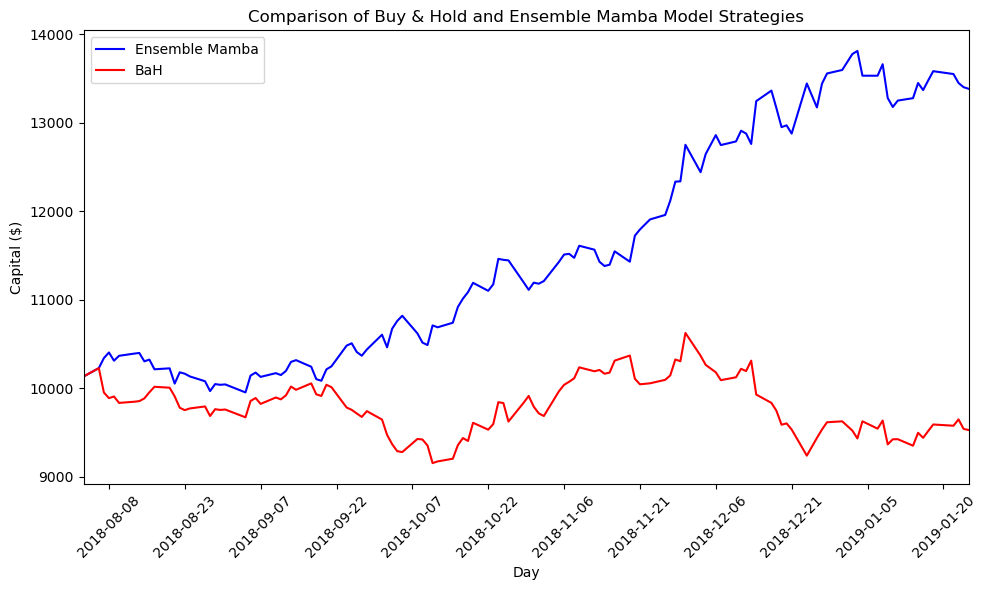

In [12]:
import matplotlib.dates as mdates
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Total_Value'], color='blue', label='Ensemble Mamba')
plt.plot(df.index, df['BH_Value'], color='red', label='BaH')
plt.xlabel('Day')
plt.ylabel('Capital ($)')
plt.title('Comparison of Buy & Hold and Ensemble Mamba Model Strategies')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.xticks(rotation=45)  
plt.xlim([df.index.min(), df.index.max()])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import os
pid = os.getpid()
!kill -9 $pid